In [1]:
%matplotlib inline
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle, Arc
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import NMF

In [2]:
def load_data(dirname, filename):
    currdir = os.getcwd()
    datadir = os.path.abspath(os.path.join(currdir, dirname))
    return os.path.abspath(os.path.join(datadir, filename))

## Get data
- get FG of retained players
- get list of retained players

In [3]:
dirname = 'outputs/data/'
filename = 'players-retained-fg.csv'

fg_df = pd.read_csv(load_data(dirname, filename))

In [4]:
fg_df

,Unnamed: 0,team,opponent,made,x,y,num,player,points,shot_type,date,venue,made_points
0,0,NU,UST,0,8,3,9,J. Clemente,2,jump shot,2018.09.08,MOA,0
1,1,NU,UST,1,0,2,10,I. Gaye,2,dunk,2018.09.08,MOA,2
2,2,NU,UST,1,-1,16,8,A. Joson,2,jump shot,2018.09.08,MOA,2
3,3,NU,UST,0,4,8,1,D. Ildefonso,2,jump shot,2018.09.08,MOA,0
4,4,NU,UST,0,62,43,1,D. Ildefonso,3,jump shot,2018.09.08,MOA,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7100,7605,ADU,FEU,1,13,5,4,C. Catapusan,2,jump shot,2018.11.18,MOA,2
7101,7606,ADU,FEU,1,-34,11,7,J. Lastimosa,2,jump shot,2018.11.18,MOA,2
7102,7607,ADU,FEU,0,4,3,11,J. Espeleta,2,jump shot,2018.11.18,MOA,0
7103,7608,ADU,FEU,0,-34,-12,7,J. Lastimosa,3,jump shot,2018.11.18,MOA,0


In [5]:
players = pd.read_csv(load_data(dirname, 'players-retained-sorted.csv'))

In [6]:
# players.player[0]

## Draw court

In [7]:
def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 46cm so it has a radius of 23cm, which is a value
    # 2.3 in our coordinate system
    hoop = Circle((0, 0), radius=2.3, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-9, -2.3), 18, -0.1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=4.9m, height=5.8m
    outer_box = Rectangle((-24.45, -14.3), 49, 58, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=3.6ft, height=5.8ft
    inner_box = Rectangle((-18, -14.3), 36, 58, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 43.7), 36, 36, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 43.7), 36, 36, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 25, 25, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 2.68m long before they begin to arc
    corner_three_a = Rectangle((-66, -14.3), 0, 28.8, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((66, -14.3), 0, 28.8, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 6.75m away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 135, 135, theta1=12, theta2=168, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 125.7), 36, 36, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 125.7), 12, 12, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [
        hoop,
        backboard,
        outer_box,
        inner_box,
        top_free_throw,
        bottom_free_throw,
        restricted,
        corner_three_a,
        corner_three_b,
        three_arc,
        center_outer_arc,
        center_inner_arc
    ]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-75, -14.3), 150, 140, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

## Show shot chart of shooter

In [8]:
def show_shot_chart(shooter, title="shot chart"):

    plt.figure(figsize=(12,11))
    plt.scatter(shooter.x, shooter.y, c='green', s=3)

    draw_court(outer_lines=True)

    plt.xlim(-80,80)
    plt.ylim(-20, 140)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.gca().set_facecolor('#ffffff')
    plt.gca().set_title(title)

    plt.show()

## Generate court grid

In [9]:
def generate_xy_grids(xrange, yrange):
    x = np.arange(xrange[0], xrange[1], xrange[2])
    y = np.arange(yrange[0], yrange[1], yrange[2])

    return np.meshgrid(x, y)

## Get locations from dataframe for KDE

In [10]:
def get_locations(df):
    # each row of the array represents the x,y location of the FG (FG x 2 array)
    return np.vstack([df.x, df.y]).T

## Get kernel density estimates of court cells based a set of FG

In [11]:
def get_kde_court(locs, xy, **kde_options):
    kde = KernelDensity(bandwidth=kde_options['bandwidth'], kernel=kde_options['kernel']).fit(locs)    
    return np.exp(kde.score_samples(xy))

## NMF

In [18]:
def do_nmf(df, players, k, m, n, beta_loss='kullback-leibler',solver='mu',init='nndsvda', savenmf=True, saveplt=False):
    
    outname = 'outputs/img/{}_{}_{}_{}_{}x{}'.format(beta_loss, solver, init, k, m, n)
    model = NMF(n_components=k, max_iter=10000, beta_loss=beta_loss, solver=solver, init=init)
    samples = []
    
    xgrid, ygrid = generate_xy_grids((-75,76,5), (-15,126,5))
    xy = np.vstack([xgrid.ravel(), ygrid.ravel()]).T
    
    for i in range(players.shape[0]):
        shooter = df[df.player==players.player[i]]
        if shooter.shape[0] > 14:
            locs =  get_locations(shooter)
            z = get_kde_court(locs, xy, bandwidth=5, kernel='gaussian')
            samples.append(z)
        else:
            pass
    shots = np.vstack(samples)
    nmf_W = model.fit_transform(shots)
    nmf_H = model.components_
    
    f1, axs1 = plt.subplots(m,n,figsize=(24,22))
    f1.set_tight_layout(True)
    
    for i in range(nmf_H.shape[0]):
        z = nmf_H[i].reshape(xgrid.shape)
        levels = np.linspace(0, z.max(), 50)
        plt.subplot(m,n,i+1)
        plt.contourf(xgrid, ygrid, z, levels=levels, cmap=plt.cm.YlOrRd)
        draw_court(outer_lines=True)

        plt.xlim(-80,80)
        plt.ylim(-20, 140)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.gca().set_title('Component {}'.format(i))
    
    if savenmf:
        pd.DataFrame(nmf_W).to_csv('outputs/data/nmf_weights.csv')
        pd.DataFrame(nmf_H).to_csv('outputs/data/nmf_basis.csv')
        
    if saveplt:
        plt.savefig(outname)


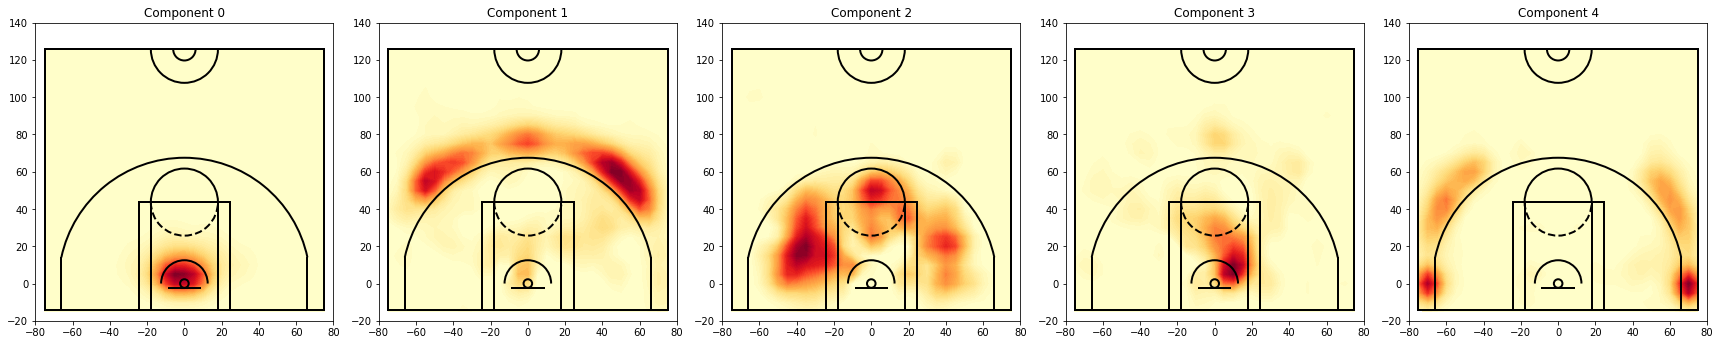

In [19]:
# number of basis
k = 5
# shape of chart
m,n = 1,5

beta_loss='kullback-leibler'
solver='mu'
init='nndsvda'

do_nmf(fg_df, players, k, m, n, beta_loss, solver, init, True, True)